In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error


In [2]:
train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
print("Number of features is", train.shape[1])

Number of features is 12


In [6]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We see that some values are missing from Age, Cabin and Embarked, so we will need to fix that before using our models.

Let's see some stats of the features

In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Now let's compare the amount of people who survived with the amount of people who died.

In [8]:
survived = train.groupby('Survived').count().reset_index()
survived.head()

,Survived,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,549,549,549,549,424,549,549,549,549,68,549
1,1,342,342,342,342,290,342,342,342,342,136,340


[Text(0, 0.5, 'Number of people')]

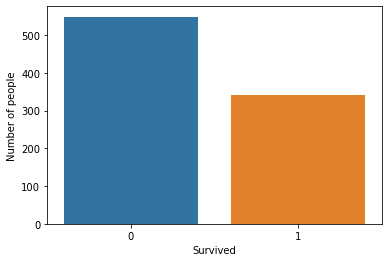

In [9]:
survived_plot = sns.barplot(x = "Survived", y = "Name", data=survived)
survived_plot.set(ylabel = "Number of people")

As we can see, almost twice as much people died then survived.

Now, Let's check how closely correlated are the categories with surviving the sinking.

In [10]:
#Possible relevant features
relevant = train
relevant = relevant.drop(columns = ["Name", "Ticket"])
relevant.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,71.2833,C85,C
2,3,1,3,female,26.0,0,0,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,53.1000,C123,S
4,5,0,3,male,35.0,0,0,8.0500,NaN,S


In [11]:
relevant["Sex"].unique()

array(['male', 'female'], dtype=object)

In [12]:
relevant["Embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [13]:
#Convert strings into numbers to use for plotting
def change_gender(sex):
    if sex == "male":
        return "1"
    else:
        return "2"

relevant["Sex"] = relevant["Sex"].apply(change_gender)
relevant["Sex"] = relevant["Sex"].astype("int")

def change_embarked(location):
    if location == "S":
        return "1"
    elif location == "C":
        return "2"
    else:
        return "3"

relevant["Embarked"] = relevant["Embarked"].apply(change_embarked)
relevant["Embarked"] = relevant["Embarked"].astype("int")


In [14]:
#Since the cabin number is reflected in Pclass, we only need one of them.
relevant.drop(columns = "Cabin")

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,1
1,2,1,1,2,38.0,1,0,71.2833,2
2,3,1,3,2,26.0,0,0,7.9250,1
3,4,1,1,2,35.0,1,0,53.1000,1
4,5,0,3,1,35.0,0,0,8.0500,1
...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.0,0,0,13.0000,1
887,888,1,1,2,19.0,0,0,30.0000,1
888,889,0,3,2,NaN,1,2,23.4500,1
889,890,1,1,1,26.0,0,0,30.0000,2


<AxesSubplot:>

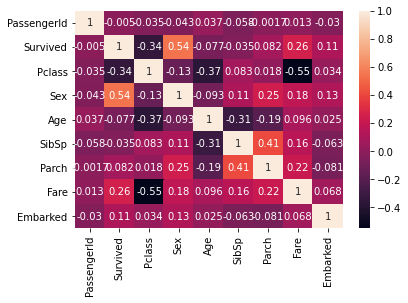

In [15]:
sns.heatmap(relevant.corr(), annot= True)

As we can see, surviving the sinking is most closely correlated to sex, then class. then fare, but the other features do not have a significant correlation with surviving.

Let's see how are the relevant features correlated to surviving.

# Gender

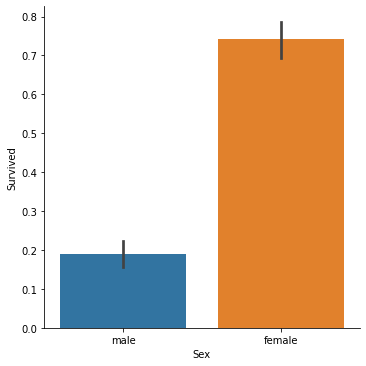

In [16]:
sesplot = sns.catplot(x="Sex", y="Survived", kind="bar", data=train)

As we can see, females are about 2.25 times more likely to survive the titanic sinking then males.

# Class

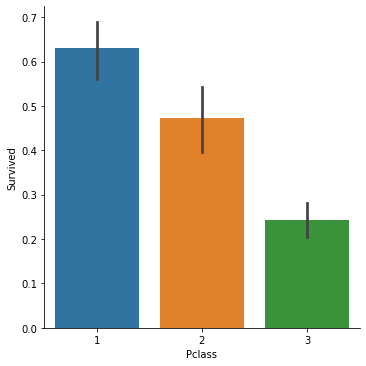

In [17]:
pclassplot = sns.catplot(x = "Pclass", y = "Survived", kind = "bar", data = train)

It seems like as the level of your classs decreases, then your survival chances also decreases. Now let's check if how many female and male of each class survived.

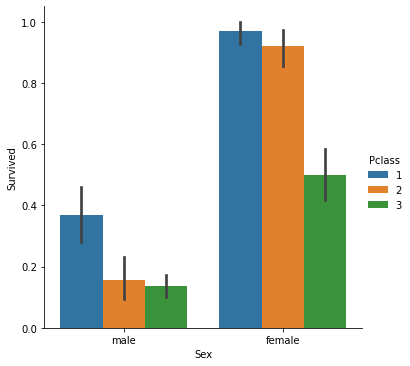

In [18]:
gender_and_class_plot = sns.catplot(x = "Sex", y = "Survived", hue = "Pclass", kind = "bar", data = train)

As we can see being a female still has a higher chance to survive no matter your class, since your chances of surviving as a female in third class is still higher than your chances of surviving as a male in first class.

# Fare

In [19]:
train["Fare"].unique()

array([  7.25  ,  71.2833,   7.925 ,  53.1   ,   8.05  ,   8.4583,
        51.8625,  21.075 ,  11.1333,  30.0708,  16.7   ,  26.55  ,
        31.275 ,   7.8542,  16.    ,  29.125 ,  13.    ,  18.    ,
         7.225 ,  26.    ,   8.0292,  35.5   ,  31.3875, 263.    ,
         7.8792,   7.8958,  27.7208, 146.5208,   7.75  ,  10.5   ,
        82.1708,  52.    ,   7.2292,  11.2417,   9.475 ,  21.    ,
        41.5792,  15.5   ,  21.6792,  17.8   ,  39.6875,   7.8   ,
        76.7292,  61.9792,  27.75  ,  46.9   ,  80.    ,  83.475 ,
        27.9   ,  15.2458,   8.1583,   8.6625,  73.5   ,  14.4542,
        56.4958,   7.65  ,  29.    ,  12.475 ,   9.    ,   9.5   ,
         7.7875,  47.1   ,  15.85  ,  34.375 ,  61.175 ,  20.575 ,
        34.6542,  63.3583,  23.    ,  77.2875,   8.6542,   7.775 ,
        24.15  ,   9.825 ,  14.4583, 247.5208,   7.1417,  22.3583,
         6.975 ,   7.05  ,  14.5   ,  15.0458,  26.2833,   9.2167,
        79.2   ,   6.75  ,  11.5   ,  36.75  ,   7.7958,  12.5

In [20]:
#Convert Fare into intervals
def Fare_Interval(Fare):
    cost = 400
    while (cost > 50):
        if Fare > cost:
            break
        cost -= 50
    return cost

def survival_percent(survive, total):
    return survive / total * 100

fare = train[['Fare', 'Survived', 'Pclass']].copy()
fare['Fare'] = fare['Fare'].apply(Fare_Interval)
fare_sum = fare.groupby('Fare').sum().reset_index()
fare_sum['Survival Rate'] = survival_percent(fare_sum['Survived'], fare_sum['Pclass'])
fare_sum.head(30)

,Fare,Survived,Pclass,Survival Rate
0,50,303,2004,15.119760
1,100,19,24,79.166667
2,150,6,9,66.666667
3,200,7,11,63.636364
4,250,4,6,66.666667
5,400,3,3,100.000000


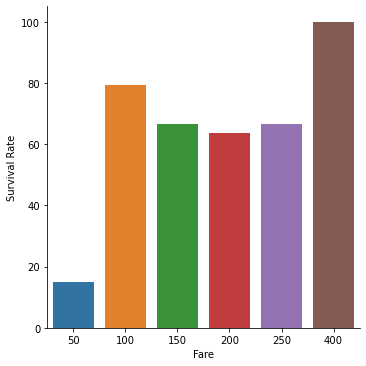

In [21]:
fareplot = sns.catplot(x = "Fare", y = "Survival Rate", kind = "bar", data = fare_sum)

<AxesSubplot:xlabel='Fare', ylabel='Survival Rate'>

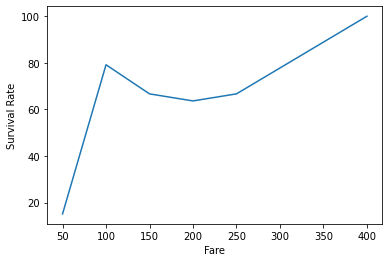

In [22]:
sns.lineplot(x = "Fare", y = "Survival Rate", data = fare_sum)

We can see that if someone paid 400+ for their fare, they survived. However, people who paid 100-150 dollars for their fare were more likely to survive than someone paying from 150-250 dollars. If someone paid less than 50 dollars, then their survival rate drastically decreased compared to the other price ranges.

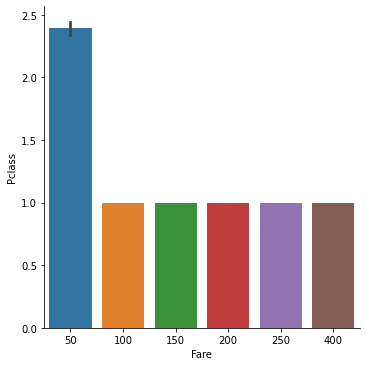

In [23]:
sns.catplot(x = "Fare", y = "Pclass", kind = "bar", data = fare)

As shown above, if you paid more than 100 dollars, you are likely to be in first class which is why as class decreases and fare goes up, your chances of surviving goes up.

# Age

In [24]:
#Convert age into intervals
def Age_Interval(age):
    age_int = 80
    while (age_int > 5):
        if age > age_int:
            break
        age_int -= 5
    return age_int

age_df = train[['Age', 'Survived']].copy()
age_df['Age'] = age_df['Age'].apply(Age_Interval)

<AxesSubplot:xlabel='Age', ylabel='Survived'>

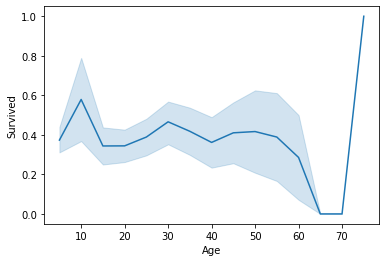

In [25]:
sns.lineplot(x = "Age", y = "Survived", data = age_df)

In [26]:
age_df['Age'].value_counts()

5     241
20    122
25    108
15     96
30     88
35     67
40     47
45     39
50     24
10     19
55     18
60     14
70      4
65      3
75      1
Name: Age, dtype: int64

We see that as age increases, the chances of surviving decreases, unless the person is above 75 years old which has a 100% chance of surviving, wow!, but the data for 60 to 80 is a bit skewed since there is only 1 person above 75 who survived and 7 people between 65 and 75 who all died.

# Siblings and Parents

In [27]:
train['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

In [28]:
train['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6], dtype=int64)

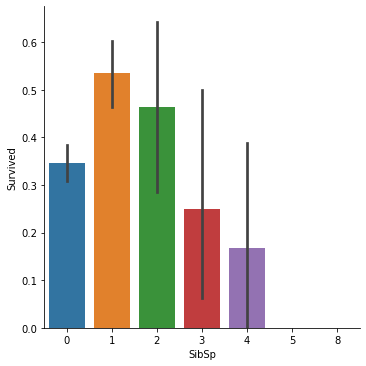

In [29]:
sibplot = sns.catplot(x = "SibSp", y = "Survived", kind = "bar", data = train)

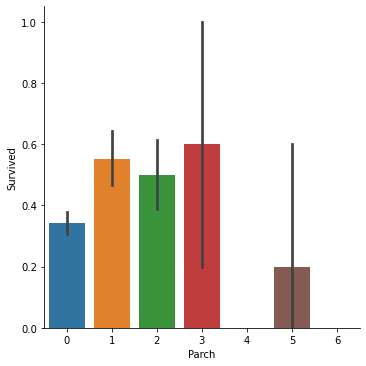

In [30]:
parchplot = sns.catplot(x = "Parch", y = "Survived", kind = "bar", data = train)

We see that if you have 1 sibling, you have the highest chance of survival, and then the chance of surivialdecreases as the number of siblings you have increases. However, for parents and children, the highest chance of survival is having 3 parents or children. Then as you move away from having 3 parents and children, your chance of surviving decreases.

# Embarked

In [31]:
train["Embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [32]:
train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

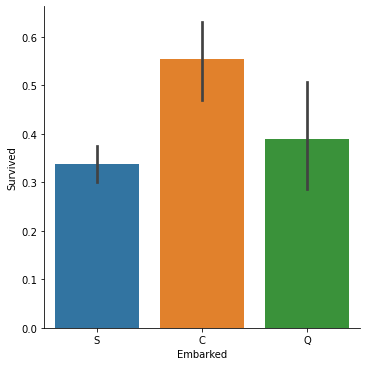

In [33]:
embarkplot = sns.catplot(x = "Embarked", y = "Survived", kind = "bar", data = train)

So, if you embarked from Cherbourg(C), you have a higher chance of surviving.

# Changing Null values and making data usuable

As stated before, cabin, ticket, and class will be closely related, so we only need one, so we can drop cabin, and we do not need name as that does not affect surviving since no one will care about who you are when they are scrambling to not drown and the sharks won't care either.

In [34]:
train_x_features = train.drop(columns = ["Name", "Ticket", "Cabin", "Survived"])
train_y_feature = train[['Survived']]
train_y_feature = pd.DataFrame(train_y_feature)

In [35]:
train_x_features['Age'].isnull().sum()

177

We are missing 177 Age values, so let's fill it with the mean

In [36]:
age_mean = train_x_features['Age'].mean()
train_x_features['Age'] = train_x_features['Age'].fillna(age_mean)

In [37]:
train_x_features['Age'].isnull().sum()

0

In [38]:
train_x_features['Embarked'].isnull().sum()

2

In [39]:
train_x_features['Embarked'].value_counts().idxmax()

'S'

Since S appears most often in Embarked, let's replace the null values with S.

In [40]:
train_x_features['Embarked'] = train_x_features['Embarked'].fillna('S')

In [41]:
train_x_features.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [42]:
train_x_features["Sex"] = train_x_features["Sex"].apply(change_gender)
train_x_features["Sex"] = train_x_features["Sex"].astype("int")

train_x_features["Embarked"] = train_x_features["Embarked"].apply(change_embarked)
train_x_features["Embarked"] = train_x_features["Embarked"].astype("int")

In [43]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [44]:
test = test.drop(columns = ["Name", "Ticket", "Cabin"])

In [45]:
test.isnull().sum()

PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64

We have null values in Age and Fare, so we need to fill these in.

In [46]:
test['Age'] = test['Age'].fillna(test['Age'].mean())
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())

In [47]:
test["Sex"] = test["Sex"].apply(change_gender)
test["Sex"] = test["Sex"].astype("int")

test["Embarked"] = test["Embarked"].apply(change_embarked)
test["Embarked"] = test["Embarked"].astype("int")

In [48]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,1,34.5,0,0,7.8292,3
1,893,3,2,47.0,1,0,7.0000,1
2,894,2,1,62.0,0,0,9.6875,3
3,895,3,1,27.0,0,0,8.6625,1
4,896,3,2,22.0,1,1,12.2875,1


# Training Models

In [49]:
train_x, test_x, train_y, test_y = train_test_split(train_x_features, train_y_feature, random_state = 10)

In [50]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(train_x, train_y)

pred_y = decision_tree.predict(test_x)
dt_accuracy = accuracy_score(test_y, pred_y) 
print(dt_accuracy * 100)

72.6457399103139


So, the accuracy score of the DecisionTreeClassifier is about 73%.

In [51]:
print(mean_absolute_error(test_y, pred_y))

0.273542600896861


In [52]:
random_forest = RandomForestClassifier()
random_forest.fit(train_x, train_y)

pred_y = random_forest.predict(test_x)
rf_accuracy = accuracy_score(test_y, pred_y) 
print(rf_accuracy * 100)

<ipython-input-52-a2a364204c60>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(train_x, train_y)


82.95964125560538


So, the accuracy score of the RandomForestClassifier is about 83%.

In [53]:
print(mean_absolute_error(test_y, pred_y))

0.17040358744394618


In [54]:
gradient_boosting = GradientBoostingClassifier()
gradient_boosting.fit(train_x, train_y)

pred_y = gradient_boosting.predict(test_x)
gb_accuracy = accuracy_score(test_y, pred_y) 
print(gb_accuracy * 100)

84.30493273542601


C:\Users\gm124\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


So, the accuracy score of the GradientBoostingClassifier is about 84%.

In [55]:
print(mean_absolute_error(test_y, pred_y))

0.15695067264573992


In [56]:
log_reg = LogisticRegression()
log_reg.fit(train_x, train_y)

pred_y = log_reg.predict(test_x)
lr_accuracy = accuracy_score(test_y, pred_y) 
print(lr_accuracy * 100)

81.16591928251121


C:\Users\gm124\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\gm124\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


So, the accuracy score of the LogisticRegression is about 81%.

In [57]:
print(mean_absolute_error(test_y, pred_y))

0.18834080717488788


Since GradientBoostingClassifier has the highest accuracy, we will try that one

In [58]:
pred_y = gradient_boosting.predict(test)
final_predict = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': pred_y})

In [59]:
final_predict

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [60]:
final_predict.to_csv("results.csv")

Overall, our model had a 77% accuracy on the test data it has never seen before